In [ ]:
# instalação do pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=736a320728e6781cc48fa7b4a84c67617c4f715cf27ef4e8fab87ef2d997473d
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
# imports da aplicação

from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.ml import Pipeline, regression as R, evaluation as E, feature as Fe
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.stat import ChiSquareTest
import pandas as pd
import seaborn as sns

In [ ]:
# Criando a sessão do spark com configurações para ter melhor desempenho

spark = SparkSession.builder.master("local[2]") \
  .config("spark.driver.memory", "6g") \
  .config("spark.executor.memory", "6g") \
  .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
  .config("spark.io.compression.codec", "snappy") \
  .config("spark.sql.adaptive.enabled", "true") \
  .appName("TrabalhoIntegrado").getOrCreate()

In [ ]:
# Carregando o dataframe e exibindo as primeiras linhas e schema
df_house = spark.read.options(header='True', inferSchema='True', delimiter=',').csv("house_prices.csv")
df_house.printSchema()
df_house.show(truncate=False)

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)

+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------

In [ ]:
# obtendo dados estatísticos do dataframe
df_house.summary().show()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd_house = df_house.toPandas()
pd_house.describe(include="all", percentiles=[.25, .50, .75, .99])

+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+------------------+
|summary|                  id|           date|             price|         bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|        sqft_above|     sqft_basement|          yr_built|      yr_renovated|           zipcode|                lat|               long|    sqft_living15|        sqft_lot15|
+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000,21613,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,...,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000
unique,NaN,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,20140623T000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4580301520.865,NaN,540088.142,3.371,2.115,2079.900,15106.968,1.494,0.008,0.234,...,7.657,1788.391,291.509,1971.005,84.402,98077.940,47.560,-122.214,1986.552,12768.456
std,2876565571.312,NaN,367127.196,0.930,0.770,918.441,41420.512,0.540,0.087,0.766,...,1.175,828.091,442.575,29.373,401.679,53.505,0.139,0.141,685.391,27304.180
min,1000102.000,NaN,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,...,1.000,290.000,0.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049194.000,NaN,321950.000,3.000,1.750,1427.000,5040.000,1.000,0.000,0.000,...,7.000,1190.000,0.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,NaN,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,...,7.000,1560.000,0.000,1975.000,0.000,98065.000,47.572,-122.230,1840.000,7620.000
75%,7308900445.000,NaN,645000.000,4.000,2.500,2550.000,10688.000,2.000,0.000,0.000,...,8.000,2210.000,560.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000


In [ ]:
# verficando se existem linhas nulas
pd_house.isnull().sum()

,0
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


In [ ]:
# verificando a frequência dos valores
cols = df_house.columns
for col in cols:
    print(pd_house[col].value_counts())
    print()

id
795000620     3
8651510380    2
2568300045    2
9353300600    2
4139480200    2
             ..
2767603649    1
1446403617    1
5602000275    1
1786200010    1
1523300157    1
Name: count, Length: 21436, dtype: int64

date
20140623T000000    142
20140626T000000    131
20140625T000000    131
20140708T000000    127
20150427T000000    126
                  ... 
20141102T000000      1
20150131T000000      1
20150524T000000      1
20140517T000000      1
20140727T000000      1
Name: count, Length: 372, dtype: int64

price
350000.000     172
450000.000     172
550000.000     159
500000.000     152
425000.000     150
              ... 
607010.000       1
1362500.000      1
298800.000       1
957500.000       1
402101.000       1
Name: count, Length: 4028, dtype: int64

bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

bathrooms
2.500    5380
1.000    3852
1.750   

In [ ]:
# verificando se há dados duplicados
pd_house.duplicated().sum()

0

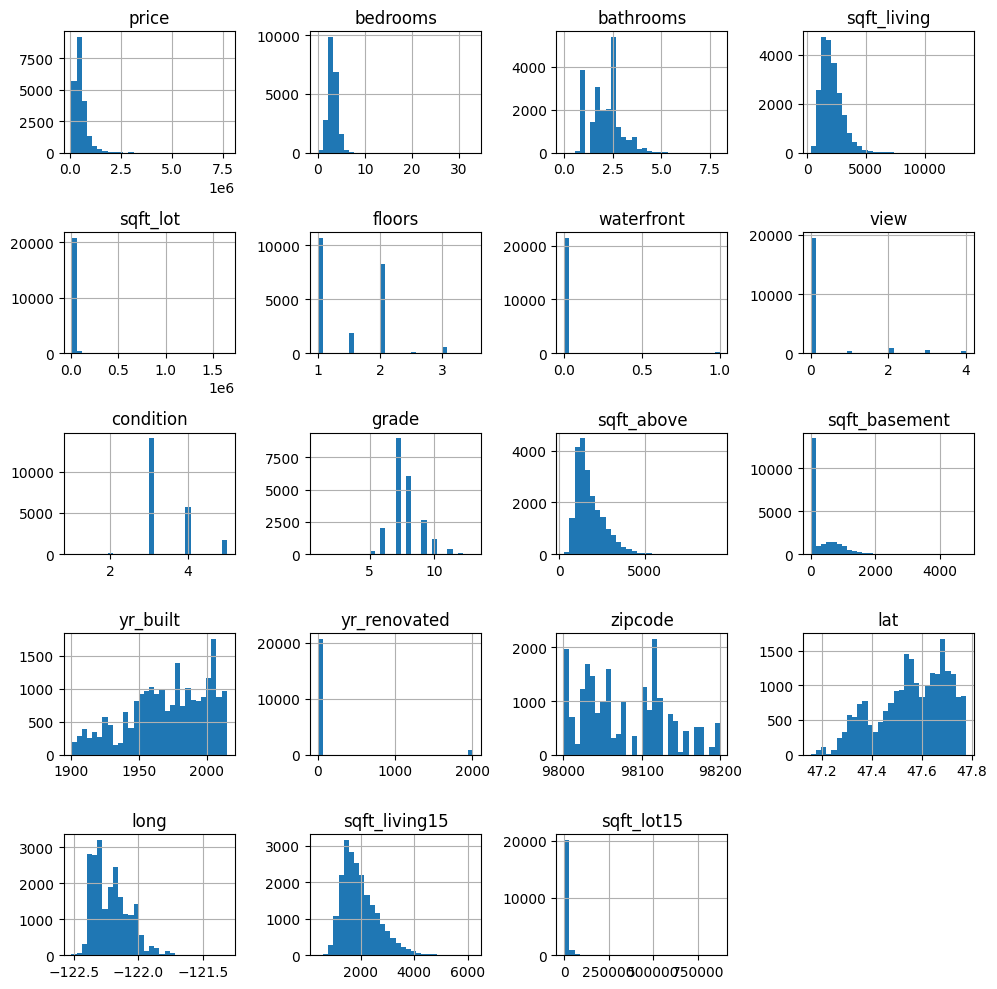

In [ ]:
# histogramas, para analisrar a distribuição dos dados
pd_house_chart = pd_house.drop(columns=["id", "date"])
pd_house_chart.hist(bins=30, figsize=(10, 10))
plt.tight_layout()
plt.show()

Percepções até o momento:
1. Não há nulos;
2. Existem bastante outliers (comparando o P99 com o max);
3. As colunas ID e DATE parecem não fazer sentido para uso no modelo, pois entendo que se referem mais ao sistema do que aos dados das casas;
  * Talvez reformatando a coluna DATE para remover o time no final possa ter algum efeito positivo;
4. Existem valores que parecem não fazer sentido, como 1.5 floor, ou 1.5 bathroom, que precisariam ser melhor entendidos.
5. A coluna waterfront tem a maioria dos valores como zero, e os poucos valores com "1" parecem refletir na coluna view;
6. A maioria das colunas não parecem seguir uma distribuição normal;
7. Talvez as colunas yr_built e yr_renovated possam ser modificadas também, para gerar algum dado mais relevante, como idade da construção, ou tempo desde renovação;

> Pesquisando sobre o dataframe, foi encontrado que a variável bathroom se refere a 1 chuveiro, 1 banheira, 1 pia e 1 vaso sanitário, e que cada item tem peso 0.25. E a variável floor, quando o andar é inteiro conta como 1, valores como 1.5 siginifica que tem um andar parcial, adicionado para mais espaço.


In [ ]:
# removendo o time da coluna date 20140623T000000
df_house = df_house.withColumn("date", F.regexp_replace(F.col("date"), "T000000", ""))
df_house = df_house.withColumn("date", F.col("date").cast(T.LongType()))

df_house.show(truncate=False)

+----------+--------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|id        |date    |price    |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat    |long    |sqft_living15|sqft_lot15|
+----------+--------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013|221900.0 |3       |1.0      |1180       |5650    |1.0   |0         |0   |3        |7    |1180      |0            |1955    |0           |98178  |47.5112|-122.257|1340         |5650      |
|6414100192|20141209|538000.0 |3       |2.25     |2570       |7242    |2.0   |0         |0   |3        |7    |2170      |400          |1951    |1991        |98125  |47.

In [ ]:
# Criando uma coluna para dizer se a casa foi renovada ou não, para substituir a coluna yr_renovated
df_house = df_house.withColumn("renovated", F.when(F.col("yr_renovated") == 0, 0).otherwise(1)).drop("yr_renovated")
df_house.show(truncate=False)

+----------+--------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+-------+-------+--------+-------------+----------+---------+
|id        |date    |price    |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|zipcode|lat    |long    |sqft_living15|sqft_lot15|renovated|
+----------+--------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+-------+-------+--------+-------------+----------+---------+
|7129300520|20141013|221900.0 |3       |1.0      |1180       |5650    |1.0   |0         |0   |3        |7    |1180      |0            |1955    |98178  |47.5112|-122.257|1340         |5650      |0        |
|6414100192|20141209|538000.0 |3       |2.25     |2570       |7242    |2.0   |0         |0   |3        |7    |2170      |400          |1951    |98125  |47.721 |-122.319|1690       

In [ ]:
df_house.columns

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'renovated']

In [ ]:
# remover os outliers e a coluna ID
df_house = df_house.drop("id")

# Obs. remover os outliers com base no P99
P_99 = 99
df_house_out = df_house.filter(F.col("price") <= np.percentile(pd_house["price"], P_99))
df_house_out = df_house_out.filter(F.col("bedrooms") <= np.percentile(pd_house["bedrooms"], P_99))
df_house_out = df_house_out.filter(F.col("bathrooms") <= np.percentile(pd_house["bathrooms"], P_99))
df_house_out = df_house_out.filter(F.col("sqft_living") <= np.percentile(pd_house["sqft_living"], P_99))
df_house_out = df_house_out.filter(F.col("sqft_lot") <= np.percentile(pd_house["sqft_lot"], P_99))
df_house_out = df_house_out.filter(F.col("floors") <= np.percentile(pd_house["floors"], P_99))
df_house_out = df_house_out.filter(F.col("sqft_above") <= np.percentile(pd_house["sqft_above"], P_99))
df_house_out = df_house_out.filter(F.col("sqft_basement") <= np.percentile(pd_house["sqft_basement"], P_99))
df_house_out = df_house_out.filter(F.col("sqft_living15") <= np.percentile(pd_house["sqft_living15"], P_99))
df_house_out = df_house_out.filter(F.col("sqft_lot15") <= np.percentile(pd_house["sqft_lot15"], P_99))

pd_house_out = df_house_out.toPandas()
pd_house_out.describe(include="all", percentiles=[.25, .50, .75, .99])

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
count,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000,20565.000
mean,20143907.655,501710.306,3.325,2.055,1982.660,10997.459,1.483,0.005,0.194,3.411,7.565,1713.590,269.070,1970.469,98079.080,47.560,-122.218,1931.079,9905.904,0.040
std,4438.231,263733.886,0.860,0.700,764.544,16261.330,0.538,0.071,0.690,0.651,1.066,719.713,400.931,29.404,53.613,0.139,0.139,614.306,12070.044,0.197
min,20140502.000,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,1.000,1.000,290.000,0.000,1900.000,98001.000,47.156,-122.512,460.000,651.000,0.000
25%,20140722.000,316000.000,3.000,1.500,1400.000,5000.000,1.000,0.000,0.000,3.000,7.000,1180.000,0.000,1951.000,98033.000,47.469,-122.331,1470.000,5023.000,0.000
50%,20141016.000,440000.000,3.000,2.250,1870.000,7478.000,1.000,0.000,0.000,3.000,7.000,1520.000,0.000,1974.000,98070.000,47.571,-122.238,1810.000,7500.000,0.000
75%,20150218.000,619500.000,4.000,2.500,2460.000,10157.000,2.000,0.000,0.000,4.000,8.000,2120.000,530.000,1996.000,98118.000,47.679,-122.130,2300.000,9765.000,0.000
99%,20150507.000,1486800.000,5.360,3.500,4066.800,90169.000,3.000,0.000,4.000,5.000,10.000,3810.000,1420.000,2014.000,98199.000,47.773,-121.786,3680.000,65340.000,1.000
max,20150527.000,1955000.000,6.000,4.250,4970.000,213008.000,3.000,1.000,4.000,5.000,12.000,4370.000,1660.000,2015.000,98199.000,47.778,-121.315,4080.000,157123.000,1.000


In [ ]:
# apenas comparando com o dataframe original
pd_house.describe(include="all", percentiles=[.25, .50, .75, .99])

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000,21613,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,...,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000
unique,NaN,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,20140623T000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4580301520.865,NaN,540088.142,3.371,2.115,2079.900,15106.968,1.494,0.008,0.234,...,7.657,1788.391,291.509,1971.005,84.402,98077.940,47.560,-122.214,1986.552,12768.456
std,2876565571.312,NaN,367127.196,0.930,0.770,918.441,41420.512,0.540,0.087,0.766,...,1.175,828.091,442.575,29.373,401.679,53.505,0.139,0.141,685.391,27304.180
min,1000102.000,NaN,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,...,1.000,290.000,0.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049194.000,NaN,321950.000,3.000,1.750,1427.000,5040.000,1.000,0.000,0.000,...,7.000,1190.000,0.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,NaN,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,...,7.000,1560.000,0.000,1975.000,0.000,98065.000,47.572,-122.230,1840.000,7620.000
75%,7308900445.000,NaN,645000.000,4.000,2.500,2550.000,10688.000,2.000,0.000,0.000,...,8.000,2210.000,560.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000


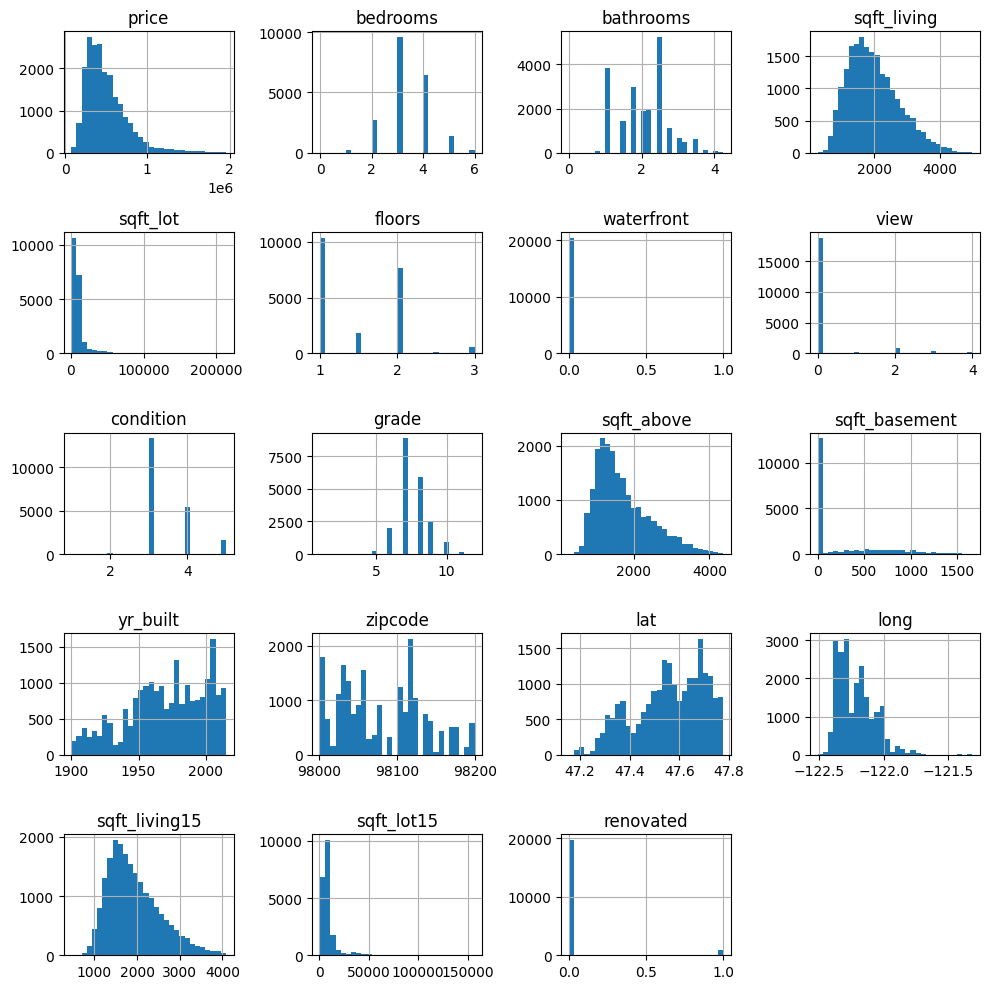

In [ ]:
# analisando os histogramas, para verificar a diferença das mudanças
pd_house_chart = pd_house_out.drop(columns=["date"])
pd_house_chart.hist(bins=30, figsize=(10, 10))
plt.tight_layout()
plt.show()

In [ ]:
# funções para criar o vetor de features e atualizar o df
def get_feature_vector(features_names) -> Fe.VectorAssembler:
  """"
  Cria e retorna um vetor de features a partir de uma lista de nomes de colunas.
  :param features_names: lista de nomes de colunas
  :return Fe.VectorAssembler: vetor de features
  """
  return Fe.VectorAssembler(inputCols=features_names, outputCol="features")

def transform_df_with_features(df, features_names):
  """
  Transforma um dataframe em um dataframe com uma coluna de features.
  :param df: dataframe a ser transformado
  :param features_names: lista de nomes de colunas
  :return df: dataframe com uma coluna de features
  """
  features = get_feature_vector(features_names)
  df = features.transform(df_house)
  return df

In [ ]:
def linear_regression(df, features_names):
  df = transform_df_with_features(df_house, features_names)

  # Separando dataframe em train e test
  df_train, df_test = df.randomSplit([0.7, 0.3], seed=997)

  # Criando modelo de regressão linear
  linear_regressor = R.LinearRegression(featuresCol="features", labelCol="price")
  linear_regressor_model = linear_regressor.fit(df_train)

  # Prevendo modelo com test
  linear_regressor_predictions = linear_regressor_model.transform(df_test)

  # Avaliando desmpenho do modelo
  linear_regressor_evaluator = E.RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
  linear_regressor_rmse = linear_regressor_evaluator.evaluate(linear_regressor_predictions)
  return linear_regressor_model, linear_regressor_predictions, linear_regressor_rmse

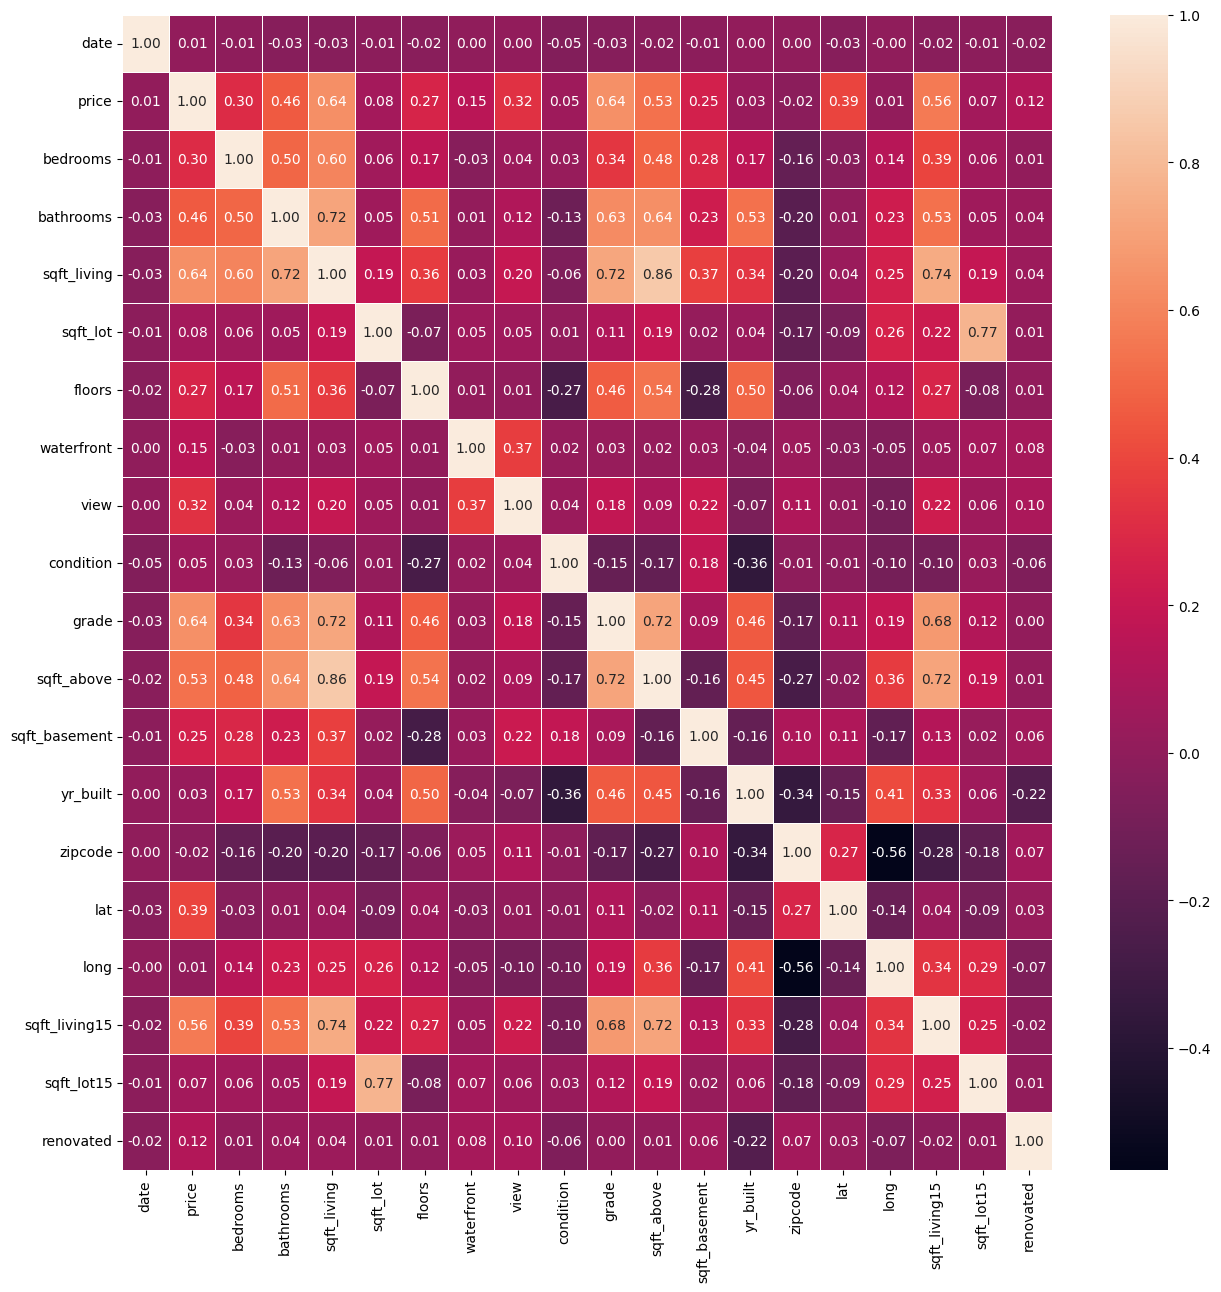

In [ ]:
# heatmap de correlacao das colunas
corr_matrix = pd_house_out.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f",linewidth=.5)
plt.show()

São poucas colunas que demonstram ter uma correlação forte com a coluna price...

In [ ]:
# Criando modelos, primeiro com praticamente todas colunas e depois com as mais relevantes
names_01 = ["date", "bedrooms", "bathrooms", "sqft_living",
         "sqft_lot", "floors", "view", "condition",
         "grade", "sqft_above", "sqft_basement",
         "yr_built", "renovated", "zipcode", "lat",
         "long", "sqft_living15", "sqft_lot15"
         ]
model_01 = linear_regression(df_house_out, names_01)

names_02 = ["sqft_living", "grade", "sqft_living15"]
model_02 = linear_regression(df_house_out, names_02)

names_03 = ["bedrooms", "bathrooms", "sqft_living",
            "floors", "view", "grade", "sqft_above",
            "sqft_basement", "renovated", "lat", "sqft_living15"
         ]
model_03 = linear_regression(df_house_out, names_03)

names_04 = names_03.copy()
names_04.remove("lat")
model_04 = linear_regression(df_house_out, names_04)

names_05 = names_04.copy()
names_05.remove("renovated")
model_05 = linear_regression(df_house_out, names_05)

print(f"RMSE model_01: {model_01[2]}")
print(f"RMSE model_02: {model_02[2]}")
print(f"RMSE model_03: {model_03[2]}")
print(f"RMSE model_04: {model_04[2]}")
print(f"RMSE model_05: {model_05[2]}")

RMSE model_01: 205048.18338036785
RMSE model_02: 250916.9056660778
RMSE model_03: 217215.70171445524
RMSE model_04: 235782.052021859
RMSE model_05: 237671.92614006746


Os modelos de regressão linear não estão tendo bons resultados nesse caso. Testar um modelo diferente, como RandomForest, ou talvez um Kneighbor...

In [ ]:
# Criar modelo de RandomForest
# from pyspark.ml import Pipeline, regression as R, evaluation as E, feature as Fe ## esse import está lá no topo do documento, copiei aqui para não esquecer dos alias da lib

def random_forest(df, features_names, regressor_params = {}):
  df = transform_df_with_features(df, features_names)
  # Definindo o maxCategories como 13, pois é o valor máximo da coluna com mais categorias (grade)
  feature_indexer = Fe.VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=13).fit(df)
  # Separando dataframe em train e test
  df_train, df_test = df.randomSplit([0.7, 0.3], seed=997)
  # Criando modelo
  random_forest_regressor = R.RandomForestRegressor(seed= 997, featuresCol="indexedFeatures", labelCol="price", **regressor_params)
  pipeline = Pipeline(stages=[feature_indexer, random_forest_regressor])

  model = pipeline.fit(df_train)

  # Fazendo as predições e validando com rmse
  predictions = model.transform(df_test)
  evaluator = E.RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions)
  return model, predictions, rmse

In [ ]:
# Criando modelos, igual aos de linear regression
rf_model_01 = random_forest(df_house_out, names_01)
rf_model_02 = random_forest(df_house_out, names_02)
rf_model_03 = random_forest(df_house_out, names_03)
rf_model_04 = random_forest(df_house_out, names_04)
rf_model_05 = random_forest(df_house_out, names_05)

print(f"RMSE model_01: {rf_model_01[2]}")
print(f"RMSE model_02: {rf_model_02[2]}")
print(f"RMSE model_03: {rf_model_03[2]}")
print(f"RMSE model_04: {rf_model_04[2]}")
print(f"RMSE model_05: {rf_model_05[2]}")

RMSE model_01: 183219.22755614747
RMSE model_02: 246127.62130405765
RMSE model_03: 200028.28550952746
RMSE model_04: 227320.17844257894
RMSE model_05: 225592.33831765904


Os resultados com random forest foram melhores, acredito que valha a pena testar alterando alguns parametros do modelo que tenham influencia no tamanho das arvores e ver se melhora.

In [ ]:
# testar a mudança dos parametros apenas com o vetor names_01
rf_model_06 = random_forest(df_house_out, names_01, {"maxDepth": 6, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_06: {rf_model_06[2]}")
rf_model_07 = random_forest(df_house_out, names_01, {"maxDepth": 7, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_07: {rf_model_07[2]}")
rf_model_08 = random_forest(df_house_out, names_01, {"maxDepth": 8, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_08: {rf_model_08[2]}")
rf_model_09 = random_forest(df_house_out, names_01, {"maxDepth": 9, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_09: {rf_model_09[2]}")
rf_model_10 = random_forest(df_house_out, names_01, {"maxDepth": 10, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_10: {rf_model_10[2]}")

RMSE model_06: 174459.46341066557
RMSE model_07: 165514.48565215542
RMSE model_08: 160707.1575477599
RMSE model_09: 156288.29065253175
RMSE model_10: 152460.63557781858


In [ ]:
# verificando a quantidade de features de cada vetor
print(len(names_01))
print(len(names_02))
print(len(names_03))
print(len(names_04))
print(len(names_05))

18
3
11
10
9


In [ ]:
# considerando que quanto mais profunda as árvores mais informação do dataset o modelo consegue capturar,
#   e o aumento desse parametro realmente melhora o desempenho do modelo
#   acredito que, para a lista de features names_01, que possuí 18 features,
#   seria razoável testar o maxDepth com algo entre 18 e 30 (valor máximo no spark), de forma que as árvores possam tentar analisar cada uma das features
rf_model_11 = random_forest(df_house_out, names_01, {"maxDepth": 18, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_11: {rf_model_11[2]}")
rf_model_12 = random_forest(df_house_out, names_01, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_12: {rf_model_12[2]}")
rf_model_13 = random_forest(df_house_out, names_01, {"maxDepth": 28, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_13: {rf_model_13[2]}")
rf_model_14 = random_forest(df_house_out, names_01, {"maxDepth": 30, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_14: {rf_model_14[2]}")

RMSE model_11: 147521.8191935019
RMSE model_12: 147463.24935994373
RMSE model_13: 147478.21516682502
RMSE model_14: 147478.3644083414


In [ ]:
# testar mudando o featureSubsetStrategy do modelo 12, que teve o melhor desempenho até o momento
rf_model_15 = random_forest(df_house_out, names_01, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "all", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_15: {rf_model_15[2]}")
rf_model_16 = random_forest(df_house_out, names_01, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "sqrt", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_16: {rf_model_16[2]}")
rf_model_17 = random_forest(df_house_out, names_01, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "log2", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_17: {rf_model_17[2]}")

RMSE model_15: 146232.10512580373
RMSE model_16: 148550.44941754173
RMSE model_17: 148550.44941754173


In [ ]:
# testar mudando o minInfoGain para o modelo 15
rf_model_18 = random_forest(df_house_out, names_01, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "all", "minInfoGain": 0.01, "maxMemoryInMB": 1024})
print(f"RMSE model_18: {rf_model_18[2]}")
rf_model_19 = random_forest(df_house_out, names_01, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "all", "minInfoGain": 0.1, "maxMemoryInMB": 1024})
print(f"RMSE model_19: {rf_model_19[2]}")
rf_model_20 = random_forest(df_house_out, names_01, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "all", "minInfoGain": 0.2, "maxMemoryInMB": 1024})
print(f"RMSE model_20: {rf_model_20[2]}")

RMSE model_18: 146232.10512580373
RMSE model_19: 146232.10512580373
RMSE model_20: 146232.10512396504


In [ ]:
# sem melhoras com esse parametro.
# testar com os outros subsets de features também, para ver se algum acaba tendo um desempenho melhor
rf_model_21 = random_forest(df_house_out, names_02, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "all", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_21: {rf_model_21[2]}")
rf_model_22 = random_forest(df_house_out, names_03, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "all", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_22: {rf_model_22[2]}")
rf_model_23 = random_forest(df_house_out, names_04, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "all", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_23: {rf_model_23[2]}")
rf_model_24 = random_forest(df_house_out, names_05, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "all", "minInfoGain": 0.05, "maxMemoryInMB": 1024})
print(f"RMSE model_24: {rf_model_24[2]}")

RMSE model_21: 259901.7908546515
RMSE model_22: 172966.9916276365
RMSE model_23: 226717.00194958653
RMSE model_24: 228676.61310491417


In [ ]:
# rf_model_25 = random_forest(df_house, names_02, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 512})
# print(f"RMSE model_25: {rf_model_25[2]}")
# rf_model_26 = random_forest(df_house, names_03, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 512})
# print(f"RMSE model_26: {rf_model_26[2]}")
# rf_model_27 = random_forest(df_house, names_04, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 512})
# print(f"RMSE model_27: {rf_model_27[2]}")
# rf_model_28 = random_forest(df_house, names_05, {"maxDepth": 23, "maxBins": 50, "featureSubsetStrategy": "onethird", "minInfoGain": 0.05, "maxMemoryInMB": 512})
# print(f"RMSE model_28: {rf_model_28[2]}")

## esses testes falharam com OutOfMemory, vou testar o algoritmo de randomforest da sklearn

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# pd_house_out

def random_forest_sklearn(df_pandas, features_names, model_params={}):
  x = df_pandas[features_names]
  y = df_pandas["price"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

  model = RandomForestRegressor(random_state=1, **model_params)
  model.fit(x_train, y_train)
  rfr_pred_test = model.predict(x_test)

  return model, rfr_pred_test, root_mean_squared_error(y_test, rfr_pred_test)

In [ ]:
rf_model_25 = random_forest_sklearn(pd_house_out, names_01, {"n_estimators": 50})
print(f"RMSE model_25: {rf_model_25[2]}")
rf_model_26 = random_forest_sklearn(pd_house_out, names_01, {"n_estimators": 100})
print(f"RMSE model_26: {rf_model_26[2]}")
rf_model_27 = random_forest_sklearn(pd_house_out, names_01, {"n_estimators": 150})
print(f"RMSE model_27: {rf_model_27[2]}")

RMSE model_25: 94209.03780707053
RMSE model_26: 93823.80820374122
RMSE model_27: 93594.38128974145


Os resultados com esse modelo estão muito melhores.
Testar com os outros vetores de features também

In [ ]:
rf_model_28 = random_forest_sklearn(pd_house_out, names_02, {"n_estimators": 50})
print(f"RMSE model_28: {rf_model_28[2]}")
rf_model_29 = random_forest_sklearn(pd_house_out, names_03, {"n_estimators": 50})
print(f"RMSE model_29: {rf_model_29[2]}")
rf_model_30 = random_forest_sklearn(pd_house_out, names_04, {"n_estimators": 50})
print(f"RMSE model_30: {rf_model_30[2]}")
rf_model_31 = random_forest_sklearn(pd_house_out, names_05, {"n_estimators": 50})
print(f"RMSE model_31: {rf_model_31[2]}")

RMSE model_28: 203113.87372059064
RMSE model_29: 121401.99265969181
RMSE model_30: 173125.8138513349
RMSE model_31: 174100.25594724438


In [ ]:
# testar novas mudanças no modelo, usando o vetor names_01
rf_model_32 = random_forest_sklearn(pd_house_out, names_01, {"n_estimators": 50, "criterion": "absolute_error", "min_impurity_decrease": 0.1})
print(f"RMSE model_32: {rf_model_32[2]}")
rf_model_33 = random_forest_sklearn(pd_house_out, names_01, {"n_estimators": 50, "criterion": "friedman_mse", "min_impurity_decrease": 0.1})
print(f"RMSE model_33: {rf_model_33[2]}")
rf_model_34 = random_forest_sklearn(pd_house_out, names_01, {"n_estimators": 50, "criterion": "poisson", "min_impurity_decrease": 0.1})
print(f"RMSE model_34: {rf_model_34[2]}")

RMSE model_32: 94194.60403123994
RMSE model_33: 94202.99307957475
RMSE model_34: 93790.09287357332


In [ ]:
rf_model_35 = random_forest_sklearn(pd_house_out, names_01, {"n_estimators": 50, "criterion": "poisson", "min_impurity_decrease": 0.9})
print(f"RMSE model_35: {rf_model_35[2]}")
rf_model_36 = random_forest_sklearn(pd_house_out, names_01, {"n_estimators": 50, "criterion": "poisson", "min_impurity_decrease": 0.1, "bootstrap": False})
print(f"RMSE model_36: {rf_model_36[2]}")

RMSE model_35: 94094.29224700399
RMSE model_36: 129010.26078802327


Testando outros modelos

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

def extra_trees_regressor(df_pandas, features_names, model_params={}):
  x = df_pandas[features_names]
  y = df_pandas["price"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

  model = ExtraTreesRegressor(random_state=1, **model_params)
  model.fit(x_train, y_train)
  rfr_pred_test = model.predict(x_test)

  return model, rfr_pred_test, root_mean_squared_error(y_test, rfr_pred_test)

In [ ]:
rf_model_37 = extra_trees_regressor(pd_house_out, names_01)
print(f"RMSE model_37: {rf_model_37[2]}")
rf_model_38 = extra_trees_regressor(pd_house_out, names_02)
print(f"RMSE model_38: {rf_model_38[2]}")
rf_model_39 = extra_trees_regressor(pd_house_out, names_03)
print(f"RMSE model_39: {rf_model_39[2]}")
rf_model_40 = extra_trees_regressor(pd_house_out, names_04)
print(f"RMSE model_40: {rf_model_40[2]}")
rf_model_41 = extra_trees_regressor(pd_house_out, names_05)
print(f"RMSE model_41: {rf_model_41[2]}")

RMSE model_37: 94492.89175624294
RMSE model_38: 211747.53868328952
RMSE model_39: 119351.10096065771
RMSE model_40: 176101.67563817394
RMSE model_41: 176944.11850029213


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boosting_regressor(df_pandas, features_names, model_params={}):
  x = df_pandas[features_names]
  y = df_pandas["price"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

  model = GradientBoostingRegressor(random_state=1, **model_params)
  model.fit(x_train, y_train)
  rfr_pred_test = model.predict(x_test)

  return model, rfr_pred_test, root_mean_squared_error(y_test, rfr_pred_test)

In [ ]:
rf_model_42 = extra_trees_regressor(pd_house_out, names_01)
print(f"RMSE model_42: {rf_model_42[2]}")
rf_model_43 = extra_trees_regressor(pd_house_out, names_02)
print(f"RMSE model_43: {rf_model_43[2]}")
rf_model_44 = extra_trees_regressor(pd_house_out, names_03)
print(f"RMSE model_44: {rf_model_44[2]}")
rf_model_45 = extra_trees_regressor(pd_house_out, names_04)
print(f"RMSE model_45: {rf_model_45[2]}")
rf_model_46 = extra_trees_regressor(pd_house_out, names_05)
print(f"RMSE model_46: {rf_model_46[2]}")

RMSE model_42: 94492.89175624294
RMSE model_43: 211747.53868328952
RMSE model_44: 119351.10096065771
RMSE model_45: 176101.67563817394
RMSE model_46: 176944.11850029213


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

def hist_gradient_boosting_regressor(df_pandas, features_names, model_params={}):
  x = df_pandas[features_names]
  y = df_pandas["price"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

  model = HistGradientBoostingRegressor(random_state=1, **model_params)
  model.fit(x_train, y_train)
  rfr_pred_test = model.predict(x_test)

  return model, rfr_pred_test, root_mean_squared_error(y_test, rfr_pred_test)

In [ ]:
rf_model_47 = hist_gradient_boosting_regressor(pd_house_out, names_01)
print(f"RMSE model_47: {rf_model_47[2]}")
rf_model_48 = hist_gradient_boosting_regressor(pd_house_out, names_02)
print(f"RMSE model_48: {rf_model_48[2]}")
rf_model_49 = hist_gradient_boosting_regressor(pd_house_out, names_03)
print(f"RMSE model_49: {rf_model_49[2]}")
rf_model_50 = hist_gradient_boosting_regressor(pd_house_out, names_04)
print(f"RMSE model_50: {rf_model_50[2]}")
rf_model_51 = hist_gradient_boosting_regressor(pd_house_out, names_05)
print(f"RMSE model_51: {rf_model_51[2]}")

RMSE model_47: 88535.31359386092
RMSE model_48: 185431.04913938124
RMSE model_49: 117345.74584009971
RMSE model_50: 167141.59505450333
RMSE model_51: 167914.0733849008


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR

def stacking_regressor(df_pandas, features_names, model_params={}):
  x = df_pandas[features_names]
  y = df_pandas["price"]

  estimators = [('lr', RidgeCV()), ('svr', LinearSVR(random_state=1, max_iter=10_000))]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

  model = StackingRegressor(estimators=estimators,
                            final_estimator=RandomForestRegressor(n_estimators=50, random_state=42), **model_params)
  model.fit(x_train, y_train)
  rfr_pred_test = model.predict(x_test)

  return model, rfr_pred_test, root_mean_squared_error(y_test, rfr_pred_test)

In [ ]:
rf_model_52 = stacking_regressor(pd_house_out, names_01)
print(f"RMSE model_52: {rf_model_52[2]}")
rf_model_53 = stacking_regressor(pd_house_out, names_02)
print(f"RMSE model_53: {rf_model_53[2]}")
rf_model_54 = stacking_regressor(pd_house_out, names_03)
print(f"RMSE model_54: {rf_model_54[2]}")
rf_model_55 = stacking_regressor(pd_house_out, names_04)
print(f"RMSE model_55: {rf_model_55[2]}")
rf_model_56 = stacking_regressor(pd_house_out, names_05)
print(f"RMSE model_56: {rf_model_56[2]}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

RMSE model_52: 155011.753583328
RMSE model_53: 198720.9165528736
RMSE model_54: 167122.68393787774
RMSE model_55: 194373.52650635454
RMSE model_56: 194406.98385222154


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

def ada_boost_regressor(df_pandas, features_names, model_params={}):
  x = df_pandas[features_names]
  y = df_pandas["price"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

  model = AdaBoostRegressor(random_state=1, **model_params)
  model.fit(x_train, y_train)
  rfr_pred_test = model.predict(x_test)

  return model, rfr_pred_test, root_mean_squared_error(y_test, rfr_pred_test)

In [ ]:
rf_model_57 = ada_boost_regressor(pd_house_out, names_01)
print(f"RMSE model_57: {rf_model_57[2]}")
rf_model_58 = ada_boost_regressor(pd_house_out, names_02)
print(f"RMSE model_58: {rf_model_58[2]}")
rf_model_59 = ada_boost_regressor(pd_house_out, names_03)
print(f"RMSE model_59: {rf_model_59[2]}")
rf_model_60 = ada_boost_regressor(pd_house_out, names_04)
print(f"RMSE model_60: {rf_model_60[2]}")
rf_model_61 = ada_boost_regressor(pd_house_out, names_05)
print(f"RMSE model_61: {rf_model_61[2]}")

RMSE model_57: 180866.53007163788
RMSE model_58: 205416.91929718436
RMSE model_59: 205408.67677115032
RMSE model_60: 218139.82927174997
RMSE model_61: 218433.09575852417


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

def logistic_regressor(df_pandas, features_names, model_params={}):
  x = df_pandas[features_names]
  y = df_pandas["price"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
  scaler = preprocessing.StandardScaler().fit(x_train)
  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)

  model = LogisticRegression(random_state=1, **model_params)
  model.fit(x_train, y_train)
  rfr_pred_test = model.predict(x_test)

  return model, rfr_pred_test, root_mean_squared_error(y_test, rfr_pred_test)

In [ ]:
rf_model_62 = logistic_regressor(pd_house_out, names_01, {"max_iter": 1_000})
print(f"RMSE model_62: {rf_model_62[2]}")
rf_model_63 = logistic_regressor(pd_house_out, names_02, {"max_iter": 1_000})
print(f"RMSE model_63: {rf_model_63[2]}")
rf_model_64 = logistic_regressor(pd_house_out, names_03, {"max_iter": 1_000})
print(f"RMSE model_64: {rf_model_64[2]}")
rf_model_65 = logistic_regressor(pd_house_out, names_04, {"max_iter": 1_000})
print(f"RMSE model_65: {rf_model_65[2]}")
rf_model_66 = logistic_regressor(pd_house_out, names_05, {"max_iter": 1_000})
print(f"RMSE model_66: {rf_model_66[2]}")

RMSE model_62: 176051.3531363428
RMSE model_63: 201386.69731932538
RMSE model_64: 186504.4046113332
RMSE model_65: 203699.23169250664
RMSE model_66: 204290.81973966717


Até o momento, os modelos não conseguem chegar ao RMSE alvo de 69000. Porém, com esse último modelo de logistic regressor, em que é sugerido utilizar um scaler, traz o pensamento de que talvez outros modelos possam se benificiar disso também. Inclusive, talvez realizando esse tipo de mudança do dataset pode ter um impacto positivo na correlação das features com o price.

In [ ]:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(pd_house_out)
pd_house_out_scaled = scaler.transform(pd_house_out)

corr_matrix = pd_house_out_scaled.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f",linewidth=.5)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'